# House Prices - Advanced Regression Techniques
Predict Sales Prices and Practice Feature Engineering, RFs, and gradient boosting

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=test.csv

참고자료 : https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

문제 해결 방법

1. 문제 이해
2. 통합변수 연구 : 'SalePrice'라는 종속 변수에만 집중
3. 다변수 연구 : 독립변수와 종속변수 간의 관계 파악
4. Basic Cleaning : Missing Data, Ouliter, 범주형 변수(categorial variables) 다루기
5. 가정

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename = '/content/drive/MyDrive/KagglePractice/20211212_HousePrice/train.csv'
df_train = pd.read_csv(filename)

In [4]:
# column값 확인
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 1. 확인해봐야 할 사항

데이터에 대해 이해하기 위해서는, 각 변수를 확인해야 한다.

* Variable - 변수명
* Type - 수치형 데이터인지 범주형 데이터인지
(수치형 데이터의 경우, 값이 숫자로 존재하는 경우를 의미하고, 범주형 데이터의 경우, 값이 변주의 형태로 존재함을 의미한다)
* Segment - building, space or location
(building이란, 물질적인 특징이며, space란 공간적인 특징이며, location이란 위치적인 특징이다)
* Expectation - 'SalePrice'에 대한 변수의 영향에 따른 기대를 확인하기 위함이다. 'High', 'Medium', 'Low'로 구분할 수 있다. 결론에 대해 직접적인 영향을 가져오기 때문에, Sixth Sense가 필요한 부분
* Conclusion - 변수의 중요도에 대한 결론이며, Expecation과 같이, 'High', 'Medium', 'Low'로 구분할 수 있다
* Comments - 추가 설명


우리 스스로 질문해야 하는 사항은 다음과 같다.

Q1. 이 변수를 실제로 우리가 집을 매입할 때 고려하는가?

Q2. 그렇다면, 이 변수가 얼마나 중요한가? (ex. 좋은 외관을 가지는게 나쁜 외관을 가지는 것 보다 SalePrice에 가져오는 영향이 어느정도 큰가?)

Q3. 이 정보가 이미 다른 변수에 설명이 되었는가? (ex. LanContour 변수가 Property의 평평함을 보여주는 변수면, LandSlope이라는 변수에 대해 더 알 필요가 있는가?)

그렇기에 문제 해결에 결정적인 역할을 하는 변수들은 다음과 같다.
1. OverallQual (Building Variable)
2. YearBuilt (Building Variable)
3. TotalBsmtSF (Space Variable)
4. GrLivArea (Space Variable)




## 2. 첫번째 과정 : SalePrice 분석

In [5]:
# 기술통계 Summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

기술통계값을 확인해보니, 최소 가격이 0보다 크다. 크게 모델 오류를 불러일으킬 데이터값은 존재하지 않음을 확인할 수 있다.

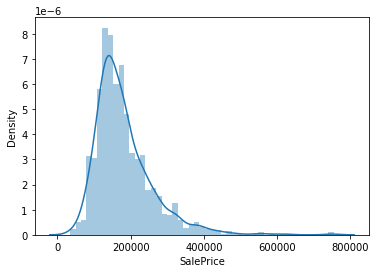

In [6]:
# 히스토그램(histogram)
sns.distplot(df_train['SalePrice'])

히스토그램을 확인한 결과 다음과 같다.
1. 정규 분포에서 벗어나있다
2. 상당한 양의 왜도를 가진다
3. 정점을 보인다

In [7]:
# 왜도 및 첨도
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


왜도

1. 왜도 < 0 : 왼쪽으로 치우쳐있다
2. 왜도 = 0 : Symmetric
3. 왜도 > 0 : 오른쪽으로 치우쳐있다

첨도

1. 첨도 < 0 : 정규분포의 형태보다는 둥근 형태
2. 첨도 = 0 : 정규분포의 형태
3. 첨도 > 0 : 뾰족한 정규분포


**수치형 변수들 사이 관계 (Relationship with Numerical Variables)**

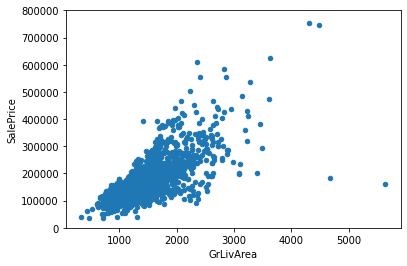

In [8]:
# 산점도 (Scatter Plot) : GrLivArea와 SalePrice과의 관계
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1) # concat함수 : 2개의 DataFrame을 하나로 합치는 과정
data.plot.scatter(x=var, y='SalePrice',ylim=(0,800000));

'SalePrice'와 'GrLivArea' 사이 선형 관계를 어느정도 유추해 볼 수 있다.